In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white'});

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
def print_and_plot(y_pred, y):
    RMSE = np.sqrt(np.mean((y_pred - y)**2))
    MAE = np.mean(np.abs(y_pred - y))
    print ('The RMSE is {:0.2f}'.format(RMSE))
    print ('The MAE is {:0.2f}'.format(MAE))
    plt.plot(y_pred, 'o', label='predicted')
    plt.plot(y, 'o', label='ground truth')
    plt.legend(loc='upper left');

In [ ]:
from sklearn.model_selection import train_test_split

feature = pd.read_csv('https://raw.githubusercontent.com/huaijiangzhu/SummerML/master/day5/fish_market_feature.csv')
label = pd.read_csv('https://raw.githubusercontent.com/huaijiangzhu/SummerML/master/day5/fish_market_label.csv')
X = feature.values
y = label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=3)

In [ ]:
pd.DataFrame(X_train).to_csv('fish_x_train.csv',index=False)
pd.DataFrame(X_val).to_csv('fish_x_test.csv',index=False)

pd.DataFrame(y_train).to_csv('fish_y_train.csv',index=False)
pd.DataFrame(y_val).to_csv('fish_y_test.csv',index=False)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,inp_csv,label_csv):
      self.X_data=torch.Tensor(pd.read_csv(inp_csv).values)
      self.y_data=torch.Tensor(pd.read_csv(label_csv).values)

    def __getitem__(self, index):
      X = self.X_data[index]
      y = self.y_data[index]
      sample = {'X': X, 'y': y}
      return sample

    def __len__(self):
      return self.X_data.size()[0]

In [ ]:
train_dataset=CustomDataset('fish_x_train.csv','fish_y_train.csv')
valid_dataset=CustomDataset('fish_x_test.csv','fish_y_test.csv')

In [ ]:
dataloader_train = DataLoader(train_dataset, batch_size=37, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=13, shuffle=False)
dataloader_train_full_dataset = DataLoader(train_dataset, batch_size=111, shuffle=False)

for idx, sample in enumerate(dataloader_train):
    x = sample['X']
    y = sample['y']
    print (x.shape, y.shape)
    print ('\n')

torch.Size([37, 5]) torch.Size([37, 1])


torch.Size([37, 5]) torch.Size([37, 1])


torch.Size([37, 5]) torch.Size([37, 1])




In [ ]:
class MLP(nn.Module):
    def __init__(self, nin, nout, X_train):
        super().__init__()

        self.fc1 = nn.Linear(nin, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, nout)
        self.sigmoid = nn.Sigmoid()
        self.data_mu, self.data_sigma = self.normalize(X_train)
    
    def forward(self, inputs):

        inputs = (inputs - self.data_mu) / self.data_sigma
        outputs = self.sigmoid(self.fc1(inputs))
        outputs = self.sigmoid(self.fc2(outputs))
        outputs = self.fc3(outputs)

        return outputs

    def normalize(self, inputs):
        mu = torch.Tensor(np.mean(inputs,axis=0))
        sigma = torch.Tensor(np.std(inputs,axis=0))
        sigma[sigma < 1e-12] = 1.0
        return mu, sigma 


In [ ]:
n_feature = X_train.shape[1]
n_label = y_train.shape[1]
model = MLP(n_feature, n_label, X_train)
loss = nn.MSELoss(reduction='mean')

In [ ]:
import tqdm
epochs = 1000
epoch_range = tqdm.trange(epochs, unit="epoch(s)", desc="Network training")
learning_rate = 1e-3
opt = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-2)

for i in epoch_range:
  for _, sample in enumerate(dataloader_train):
    model.train()
        
    # clear gradients information from the previous iteration
    opt.zero_grad()
    # read out features and labels from the mini-batch
    x = sample['X']
    y = sample['y']

    # predict the labels using the model
    y_hat = model(x)
    # compute the loss 
    J = loss(y_hat, y)
    # compute the gradients
    J.backward()
    # update the parameters using the optimizer
    opt.step()
  
  if i % 100 == 0:
    model.eval()
    for _, sample in enumerate(dataloader_train_full_dataset):
      with torch.no_grad():
        J_train = loss(model(sample['X']), sample['y'])
      epoch_range.set_postfix({"Training loss MSE": J_train.detach().cpu().numpy()})

Network training: 100%|██████████| 1000/1000 [00:05<00:00, 183.79epoch(s)/s, Training loss MSE=791.2132]


The RMSE is 26.74
The MAE is 19.58


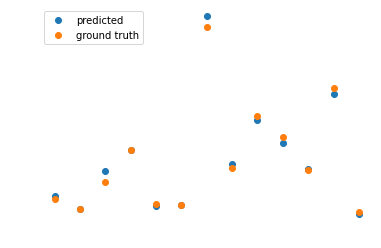

In [ ]:
model.eval()
with torch.no_grad():
  for _, sample in enumerate(dataloader_valid):
    y_hat = model(sample['X'])
    y_hat = y_hat.detach().numpy()
    y_val = sample['y'].detach().numpy()

  print_and_plot(y_hat, y_val)

The RMSE is 50.52
The MAE is 30.68


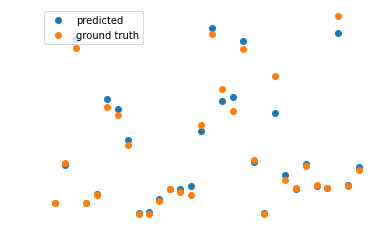

In [ ]:
X_test = pd.read_csv('https://raw.githubusercontent.com/huaijiangzhu/SummerML/master/day5/fish_market_test_feature.csv').values
y_test = pd.read_csv('https://raw.githubusercontent.com/huaijiangzhu/SummerML/master/day5/fish_market_test_label.csv').values

y_hat = model(torch.Tensor(X_test))
y_hat = y_hat.detach().numpy()

print_and_plot(y_hat, y_test)